In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random as ra
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import diptest
from scipy.stats import skew, kurtosis
import math
import timeit

plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"

This is the code for Figure 3 in the main text. All datafiles are in a folder named "Data".  

Datafiles details are below:  

MYb71 - datafile with bacterial loads for the species MYb71  
MYb120 = - datafile with bacterial loads for the species MYb120

In [2]:
def MY71code():
    
    #Follows the same code style as Fig 1 and Fig 2 except we use best parameters found through grid search  
    # and heterogenours b and c.
    
    MYb71 = pd.read_csv("../Data/MYb71.csv", delimiter=",")
    data = MYb71.dropna()
    data.shape
    

    t_data = data["Time"].to_numpy()
    N_data = data["logCFU"].to_numpy()

    Ndata_raw = MYb71["CFU"].to_numpy()
    tdata_raw = MYb71["Time"].to_numpy()

    newvar = np.log10(np.maximum(1,Ndata_raw).reshape(7,24))

    tset = [3,12,18,24,36,42,48]

    MYb71df1 = np.array(MYb71);
    MYb71_m = MYb71df1.reshape(7,24,4)

    means = np.zeros(7)
    stds = np.zeros(7)


    for i in range(7):
        stats_data = np.array(MYb71_m[i,:,-1], dtype =float)
        n = len(np.array(MYb71_m[i,:,-1], dtype =float))

        means[i] = np.nanmean(stats_data)
        stds[i] = np.nanstd(stats_data)
      
    #Set thresholds for bacterial load and calculate abundances in the data
    
    low_threshold = 1.5  
    high_threshold = 4.0  


    # Bins: 0 = Low, 1 = Medium, 2 = High
    bins = np.zeros((7, 24), dtype=int)
    abundances = np.zeros((7,3), dtype=int)


    for i in range(7):
        for j in range(24):
            ab_data = MYb71_m[i, j, -1] 

            if ab_data < low_threshold:
                bins[i, j] = 0  # Low bin
            elif low_threshold <= ab_data <= high_threshold:
                bins[i, j] = 1  # Medium bin
            else:
                bins[i, j] = 2  # High bin


            abundances[i,:] = np.bincount(bins[i], minlength=3)  
            
            
            
    def meanfieldeq(N,t,V,c,b,d):
        return c*(1-(N/V)) + b*(N)*(1-(N/V)) - d*(N)

    def fitfunc(t,V,c,b,d):
        N0 = 0.00001
        result = odeint(meanfieldeq,N0,t, args = (V,c,b,d))
        return np.log10(result[:,0])
    
    
    c_fit, ccov = curve_fit(fitfunc, t_data, N_data, p0= [100000,1, 1, 1], bounds=(0,10000000))
 
    tfit = np.linspace(0,50);
    fit = fitfunc(tfit, c_fit[0], c_fit[1], c_fit[2], c_fit[3])
    
    
    #Best Parameters from MLE grid search
    
    initial_theta = np.array([0.7482364412768554, 0.04721052780313547, 0.7868418590111479, 0.3081856639571574]) 
        
        
    nsamp = 50
    expnum = 24*nsamp

    sim_bins = np.zeros((7, expnum), dtype=int)
    sim_abundances = np.zeros((7,3), dtype=int)
    sim_probabilities = np.zeros((7,3))


    V = 500000 
    d = c_fit[3]


    tottime = 48
    tstep = 1/4
    tpnum = int(tottime/tstep)

    newtime = np.arange(0,tottime, tstep)

    gil = np.zeros((expnum,tpnum))

    for expt in range(expnum):

        t = 0.0
        N = 0.0

        b = 0
        c = 0
        while b <=d or c <= 0:
            b = np.random.normal(initial_theta[2], initial_theta[3])
            c = np.random.normal(initial_theta[0], initial_theta[1])


        step = 0

        while t < tottime:

            if t >= step*tstep:
                while step*tstep <= t:
                    gil[expt,step] = N
                    step = step + 1

                if N >=10000:
                    det_t = np.arange((step)*tstep - t,tottime-(step-1)*tstep,tstep)

                    det_N = odeint(meanfieldeq,N,det_t, args = (V,c,b,d))
                    gil[expt,step-1:] = det_N.reshape(-1)

                    break        


            E = V - N
            a1 = c*(E/V)
            a2 = b*E*(N/V)
            a3 = d*N
            a = a1 + a2 + a3
            r1 = ra.uniform(0,1)
            r2 = ra.uniform(0,1)
            tau = 1/a*math.log(1/r1)
            t = t + tau
            targeta = a*r2
            if targeta < a1:
                N = N + 1
            elif targeta < a1 + a2:
                N = N + 1
            else:
                N = N -1      

            if N <= 0:
                #break 
                N =0


        #Set thresholds for bacterial load and calculate abundances in the simulations

        sim_low_threshold = 10**1.5  
        sim_high_threshold = 10**4.0  


        for i, t_sim in enumerate([12, 48, 72, 96, 144, 168, 191]):
            simdata = gil[expt, t_sim] 

            if simdata < sim_low_threshold:
                sim_bins[i, expt] = 0  # Low bin
            elif sim_low_threshold <= simdata <= sim_high_threshold:
                sim_bins[i, expt] = 1  # Medium bin
            else:
                sim_bins[i, expt] = 2  # High bin

    for i in range(7):
        sim_abundances[i,:] = np.bincount(sim_bins[i, :], minlength=3)
        sim_probabilities = sim_abundances/expnum       
        
        
    data_llh = 0
    loglikelihood = 0
    for i in range(7):
        for j in range(3):  
            if abundances[i,j] ==0:
                loglikelihood = loglikelihood
            elif sim_probabilities[i,j] == 0:
                loglikelihood = loglikelihood + abundances[i,j]*np.log10(1/100000)  
            else:
                loglikelihood = loglikelihood + abundances[i,j]*np.log10(sim_probabilities[i,j])

    data_llh = -loglikelihood       
    
    
    sim_abundances_samp = np.zeros((7,3), dtype=int)
    trial_logs = np.zeros(nsamp)

    for sample in range(nsamp):

        for i in range(7):
            sim_abundances_samp[i,:] = np.bincount(sim_bins[i, sample*24:(sample+1)*24], minlength=3)

        loglikelihood_new = 0
        for i in range(7):
            for j in range(3):  
                if abundances[i,j] ==0:
                    loglikelihood_new = loglikelihood_new
                elif sim_probabilities[i,j] == 0:
                    loglikelihood_new = loglikelihood_new + sim_abundances_samp[i,j]*np.log10(1/100000)  
                else:
                    loglikelihood_new = loglikelihood_new + sim_abundances_samp[i,j]*np.log10(sim_probabilities[i,j])

        trial_logs[sample] = -loglikelihood_new
        

        
    #Plot the simulations against the data - shows the thresholds used for likelihood calculations as well
    plt.subplot(2, 2, 1)

    for i in range(len(np.unique(tdata_raw))):
        violin = plt.violinplot(newvar[i,:][~np.isnan(newvar[i,:])], positions = np.array([np.unique(tdata_raw)[i]]),
                       bw_method =0.3,showextrema = False, showmeans = False, widths=4,)

        for part in violin['bodies']:
            part.set_facecolor('purple')



    plt.scatter(t_data+ np.random.uniform(-1.2, 1.2, size=len(t_data)),np.maximum(0,N_data), s=60,  label='MYb71',  alpha =0.6, color = 'purple')

    plt.axhline(y = 4.0, c = 'black', ls = '--')
    plt.axhline(y = 1.5, c = 'gray', ls = '--')


    plt.plot(newtime,np.log10(np.transpose(gil[0,:])), '-', label = 'Stochastic', color = 'cornflowerblue', linewidth = 1.5)
    plt.plot(newtime, np.log10(np.transpose(gil[1:23,:])), '-', color = 'cornflowerblue')

    plt.plot(tset,means, 'p' , label = 'Mean log CFU', markersize = 11, color = 'navy')



    plt.xticks(fontsize=16)
    plt.yticks(fontsize=18)
    plt.legend(loc='upper left', fontsize = 'large')
    plt.xlabel("Time (hrs)", fontsize = 22)
    #plt.ylim(-1,14)
    plt.xlim(0,50)
    plt.ylabel(r'$\log_{10}$ Num of Bacteria', fontsize = 22)


    plt.subplot(2, 4, 3)
    plt.hist(trial_logs, density = True)
    plt.axvline(x =data_llh, c = 'r')

    plt.xlim(35,75)
    plt.ylim(0,0.18)

    plt.xlabel(r"$\mathcal{L}$", fontsize = 20)
    plt.ylabel("Frequency", fontsize = 16)


In [3]:
def MY120code():
    
    #Follows the same code style as Fig 1 and Fig 2 except we use best parameters found through grid search  
    # and heterogenours b and c.
    
    MYb120 = pd.read_csv("../Data/MYb120.csv", delimiter=",")
    data = MYb120.dropna()
    data.shape
    
    t_data = data["Time"].to_numpy()
    N_data = data["logCFU"].to_numpy()

    Ndata_raw = MYb120["CFU"].to_numpy()
    tdata_raw = MYb120["Time"].to_numpy()

    newvar = np.log10(np.maximum(1,Ndata_raw).reshape(6,24))

    tset = [12,18,24,36,42,48]

    MYb120df1 = np.array(MYb120);
    MYb120_m = MYb120df1.reshape(6,24,4)

    means = np.zeros(6)
    stds = np.zeros(6)


    for i in range(6):
        stats_data = np.array(MYb120_m[i,:,-1], dtype =float)
        n = len(np.array(MYb120_m[i,:,-1], dtype =float))

        means[i] = np.nanmean(stats_data)
        stds[i] = np.nanstd(stats_data)
        
    #Set thresholds for bacterial load and calculate abundances in the data 
    
    low_threshold = 1.0 
    high_threshold = 2.5  


    # Bins: 0 = Low, 1 = Medium, 2 = High
    bins = np.zeros((6, 24), dtype=int)
    abundances = np.zeros((6,3), dtype=int)


    for i in range(6):
        for j in range(24):
            ab_data = MYb120_m[i, j, -1] 

            if ab_data < low_threshold:
                bins[i, j] = 0  # Low bin
            elif low_threshold <= ab_data <= high_threshold:
                bins[i, j] = 1  # Medium bin
            else:
                bins[i, j] = 2  # High bin


            abundances[i,:] = np.bincount(bins[i], minlength=3) 
            
    def meanfieldeq(N,t,V,c,b,d):
        return c*(1-(N/V)) + b*(N)*(1-(N/V)) - d*(N)

    def fitfunc(t,V,c,b,d):
        N0 = 0.00001
        result = odeint(meanfieldeq,N0,t, args = (V,c,b,d))
        return np.log10(result[:,0])
    
    c_fit, ccov = curve_fit(fitfunc, t_data, N_data, p0= [100000,1, 1, 1], bounds=(0,10000000))

    tfit = np.linspace(0,50);
    fit = fitfunc(tfit, c_fit[0], c_fit[1], c_fit[2], c_fit[3])
    
     #Best Parameters from MLE grid search
    
    initial_theta = np.array([1.3365115013840507, 0.532074812228211, 1.016039845543899, 0.12889194422284986]) #run 2
   
    nsamp = 50
    expnum = 24*nsamp

    sim_bins = np.zeros((6, expnum), dtype=int)
    sim_abundances = np.zeros((6,3), dtype=int)
    sim_probabilities = np.zeros((6,3))


    V = 500000 
    d = c_fit[3]


    tottime = 48
    tstep = 1/4
    tpnum = int(tottime/tstep)

    newtime = np.arange(0,tottime, tstep)

    gil = np.zeros((expnum,tpnum))

    for expt in range(expnum):

        t = 0.0
        N = 0.0

        b = 0
        c = 0
        while b <=d or c <= 0:
            b = np.random.normal(initial_theta[2], initial_theta[3])
            c = np.random.normal(initial_theta[0], initial_theta[1])


        step = 0

        while t < tottime:

            if t >= step*tstep:
                while step*tstep <= t:
                    gil[expt,step] = N
                    step = step + 1

                if N >=10000:
                    det_t = np.arange((step)*tstep - t,tottime-(step-1)*tstep,tstep)

                    det_N = odeint(meanfieldeq,N,det_t, args = (V,c,b,d))
                    gil[expt,step-1:] = det_N.reshape(-1)

                    break        


            E = V - N
            a1 = c*(E/V)
            a2 = b*E*(N/V)
            a3 = d*N
            a = a1 + a2 + a3
            r1 = ra.uniform(0,1)
            r2 = ra.uniform(0,1)
            tau = 1/a*math.log(1/r1)
            t = t + tau
            targeta = a*r2
            if targeta < a1:
                N = N + 1
            elif targeta < a1 + a2:
                N = N + 1
            else:
                N = N -1      

            if N <= 0:
                #break 
                N =0

        
        #Set thresholds for bacterial load and calculate abundances in the simulations


        sim_low_threshold = 10**1.0  
        sim_high_threshold = 10**2.5


        for i, t_sim in enumerate([ 48, 72, 96, 144, 168, 191]):
            simdata = gil[expt, t_sim] 

            if simdata < sim_low_threshold:
                sim_bins[i, expt] = 0  # Low bin
            elif sim_low_threshold <= simdata <= sim_high_threshold:
                sim_bins[i, expt] = 1  # Medium bin
            else:
                sim_bins[i, expt] = 2  # High bin

    for i in range(6):
        sim_abundances[i,:] = np.bincount(sim_bins[i, :], minlength=3)
        sim_probabilities = sim_abundances/expnum
        
    data_llh = 0
    loglikelihood = 0
    for i in range(6):
        for j in range(3):  
            if abundances[i,j] ==0:
                loglikelihood = loglikelihood
            elif sim_probabilities[i,j] == 0:
                loglikelihood = loglikelihood + abundances[i,j]*np.log10(1/100000)  
            else:
                loglikelihood = loglikelihood + abundances[i,j]*np.log10(sim_probabilities[i,j])

    data_llh = -loglikelihood

    sim_abundances_samp = np.zeros((6,3), dtype=int)
    trial_logs = np.zeros(nsamp)

    for sample in range(nsamp):

        for i in range(6):
            sim_abundances_samp[i,:] = np.bincount(sim_bins[i, sample*24:(sample+1)*24], minlength=3)

        loglikelihood_new = 0
        for i in range(6):
            for j in range(3):  
                if abundances[i,j] ==0:
                    loglikelihood_new = loglikelihood_new
                elif sim_probabilities[i,j] == 0:
                    loglikelihood_new = loglikelihood_new + sim_abundances_samp[i,j]*np.log10(1/100000)  
                else:
                    loglikelihood_new = loglikelihood_new + sim_abundances_samp[i,j]*np.log10(sim_probabilities[i,j])

        trial_logs[sample] = -loglikelihood_new

        
    #Plot the simulations against the data - shows the thresholds used for likelihood calculations as well
    plt.subplot(2, 2, 3)

    for i in range(len(np.unique(tdata_raw))):
        violin = plt.violinplot(newvar[i,:][~np.isnan(newvar[i,:])], positions = np.array([np.unique(tdata_raw)[i]]),
                       bw_method =0.3,showextrema = False, showmeans = False, widths=4,)

        for part in violin['bodies']:
            part.set_facecolor('brown')



    plt.scatter(t_data+ np.random.uniform(-1.2, 1.2, size=len(t_data)),np.maximum(0,N_data), s=60,
                label='MYb120',  alpha =0.6, color = 'brown')

    plt.axhline(y = 2.5, c = 'black', ls = '--')
    plt.axhline(y = 1.0, c = 'gray', ls = '--')


    plt.plot(newtime,np.log10(np.transpose(gil[0,:])), '-', label = 'Stochastic', color = 'cornflowerblue', linewidth = 1.5)
    plt.plot(newtime, np.log10(np.transpose(gil[1:23,:])), '-', color = 'cornflowerblue')

    plt.plot(tset,means, 'p' , label = 'Mean log CFU', markersize = 11, color = 'navy')



    plt.xticks(fontsize=16)
    plt.yticks(fontsize=18)
    plt.legend(loc='upper left', fontsize = 'large')
    plt.xlabel("Time (hrs)", fontsize = 22)
    #plt.ylim(-1,14)
    plt.xlim(0,50)
    plt.ylabel(r'$\log_{10}$ Num of Bacteria', fontsize = 22)


    plt.subplot(2, 4, 7)
    plt.hist(trial_logs, density = True)
    plt.axvline(x =data_llh, c = 'r')

    plt.xlim(35,75)
    plt.ylim(0,0.18)

    plt.xlabel(r"$\mathcal{L}$", fontsize = 20)
    plt.ylabel("Frequency", fontsize = 16)

/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_7604/1548974493.py:219: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime,np.log10(np.transpose(gil[0,:])), '-', label = 'Stochastic', color = 'cornflowerblue', linewidth = 1.5)
/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_7604/1548974493.py:220: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime, np.log10(np.transpose(gil[1:23,:])), '-', color = 'cornflowerblue')
/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_7604/1008662870.py:213: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime,np.log10(np.transpose(gil[0,:])), '-', label = 'Stochastic', color = 'cornflowerblue', linewidth = 1.5)
/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_7604/1008662870.py:214: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime, np.log10(np.transpose(gil[1:23,:])), '-', color = 'cornflowerblue')


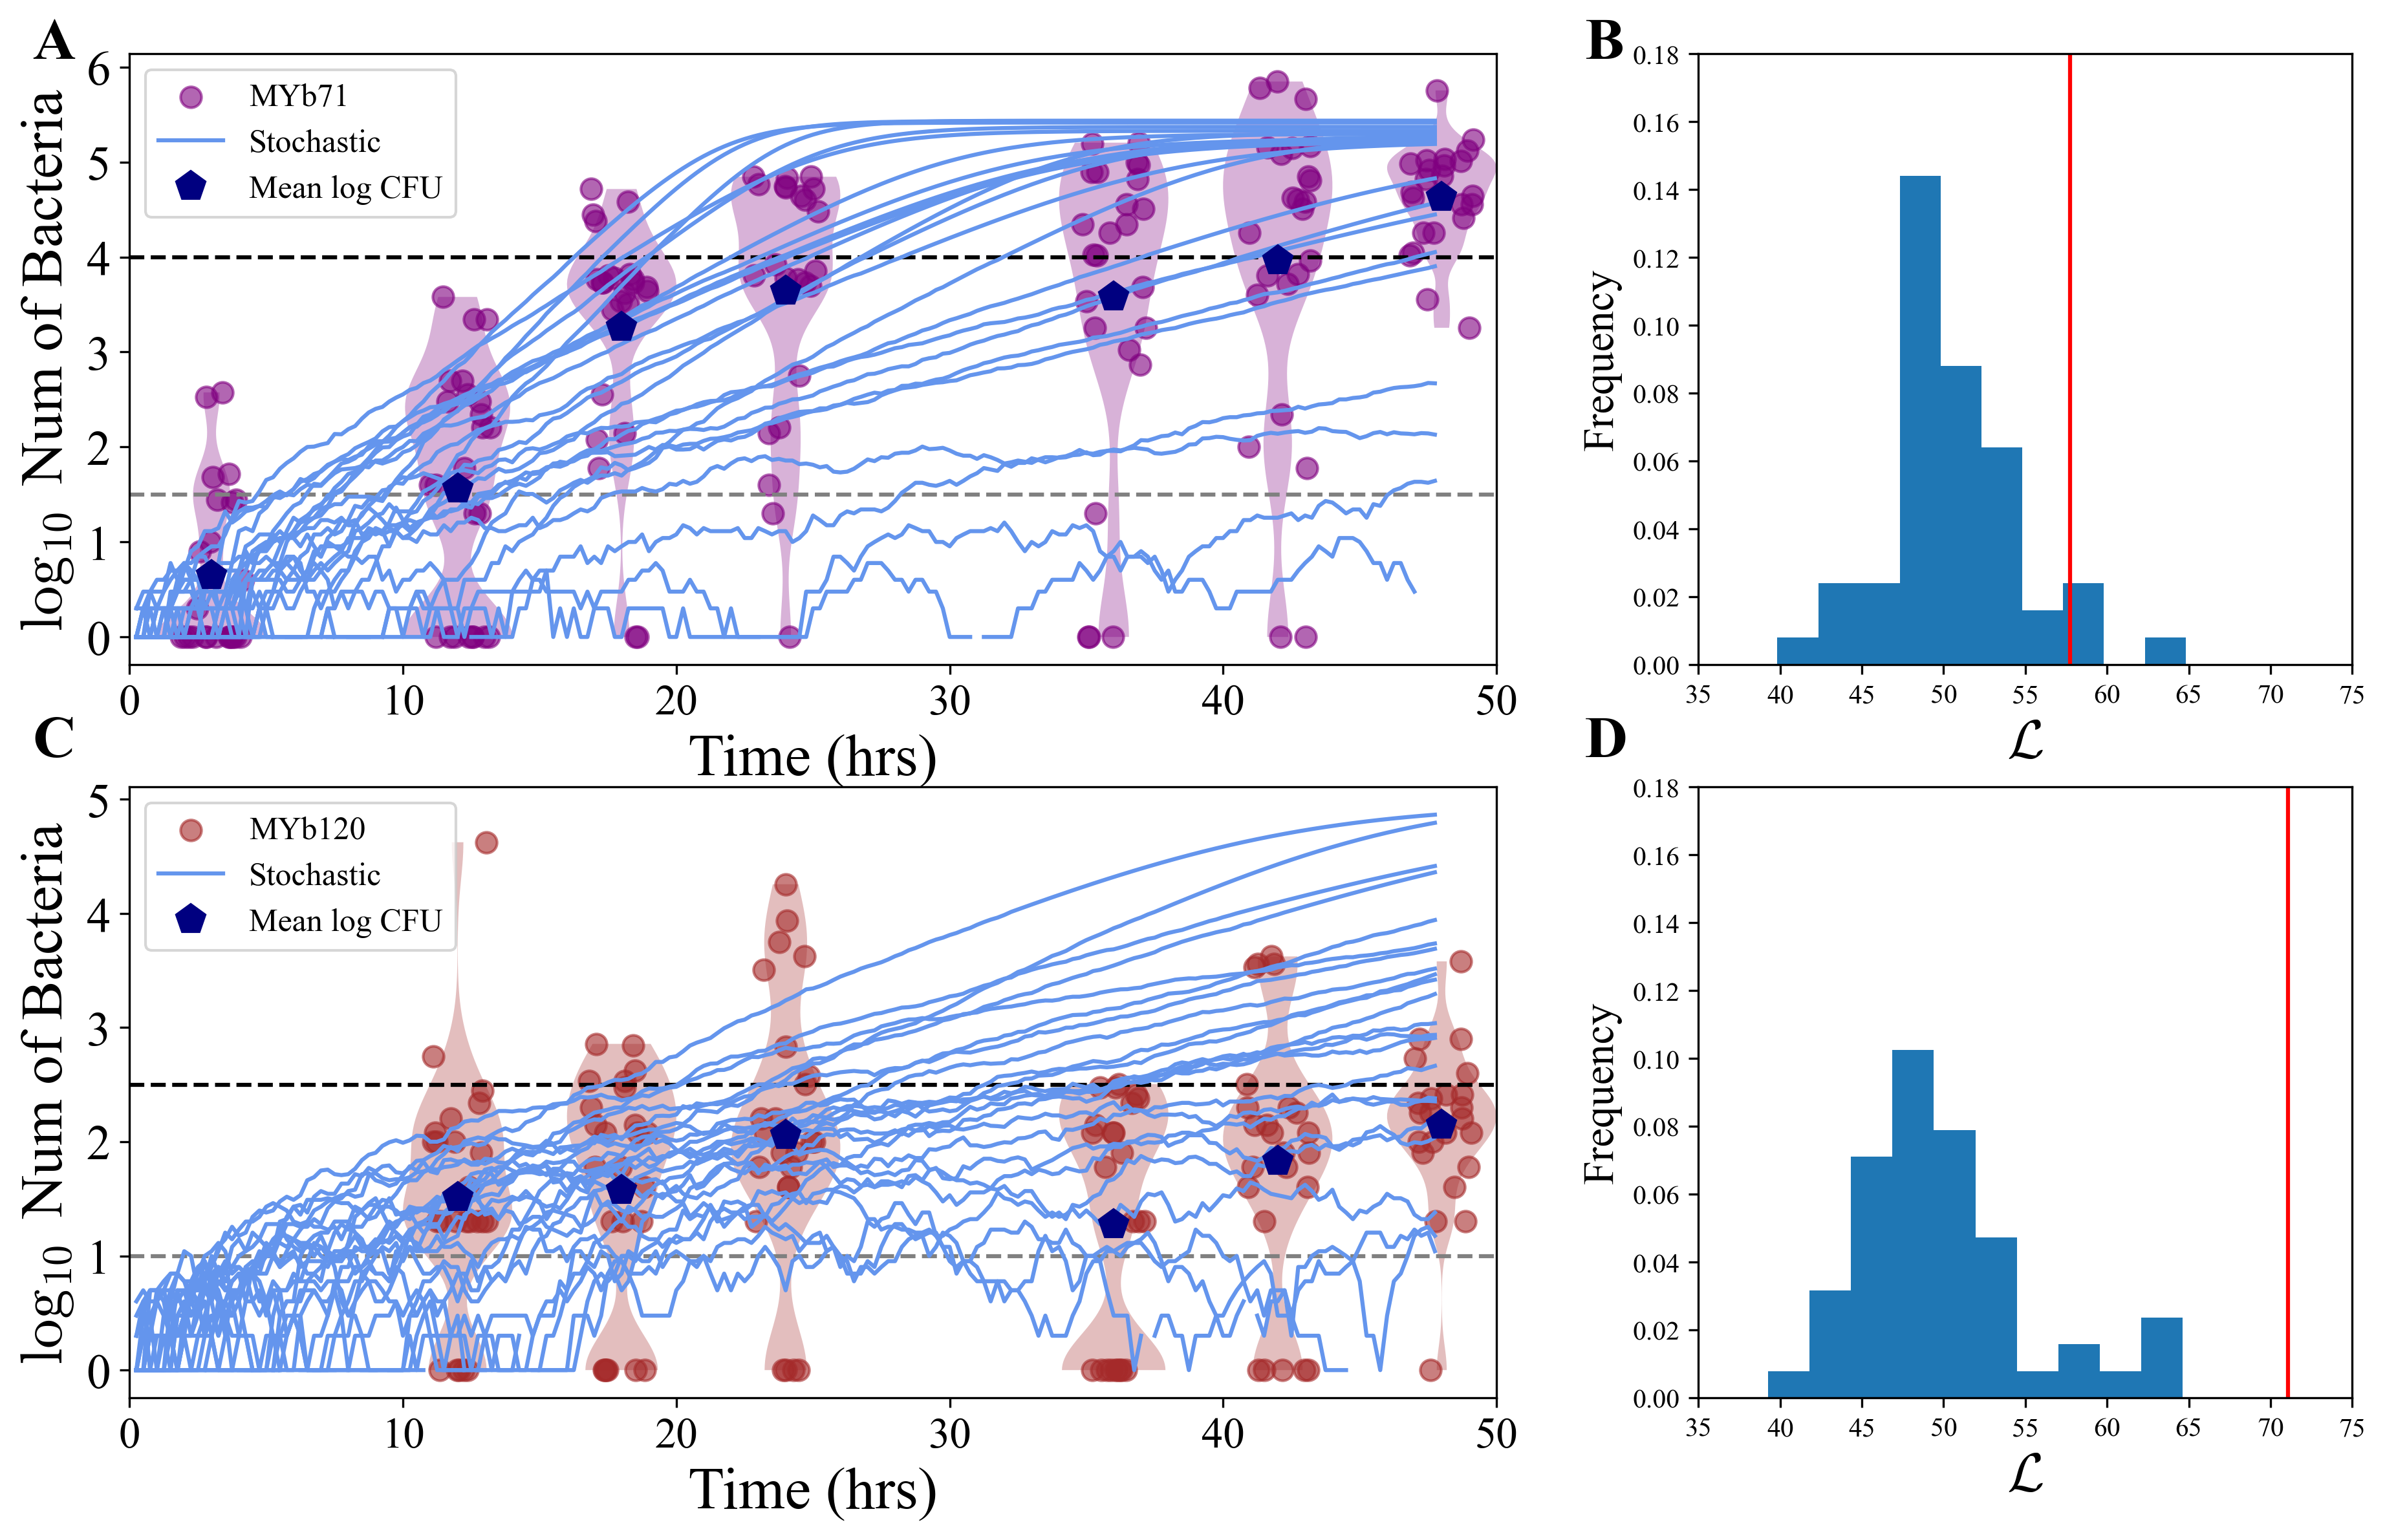

In [4]:
fig = plt.figure(figsize=(20,9))

MY71code()

MY120code()

fig.text(0.1, 0.90, "A", fontsize=22, va='top', ha='left',weight='bold')
fig.text(0.5, 0.90, "B", fontsize=22, va='top', ha='left',weight='bold')
fig.text(0.1, 0.50, "C", fontsize=22, va='top', ha='left',weight='bold')
fig.text(0.5, 0.50, "D", fontsize=22, va='top', ha='left',weight='bold')

plt.savefig("../Figures/BestParamFig3.pdf",dpi=300,  
            bbox_inches='tight')